# University of Michigan, NA/EECS 568, ROB 530
# Mobile Robotics: Methods & Algorithms, Winter 2024

## Homework 4 $-$ Mapping

- **See the course Canvas for syllabus, due dates, and homework and grading policies.**
- This course utilizes an autograder to evaluate homework. For each of the five problems, carefully read the submission instructions and complete the TODOs in the corresponding Python script. Once you have finished coding, upload all scripts to GradeScope for automatic assessment and grading. Please note, the autograder retains only the latest score, not the highest.
- For each problem, the autograder will check the **return value** of the function you implement. Additionally, the variables are printed in this notebook for you to review.

In [11]:
# run this block to enable autoreload of modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1) Discrete Counting Sensor Model

Assuming we are updating the $i$-th map cell $m_i$. We define the measurements $Y = \{y_1, ..., y_N | y_j \in \{0, 1\}\}$ indicating whether a beam was reflected by ($y_j = 1$) or passed through ($y_j = 0$) the map cell $m_i$.


Adopting a conjugate model (more detail in Robotic Mapping slide 10-15), we have the
prior over $\theta_i$ given by $Beta(\alpha_0, \beta_0)$, where $\alpha_0, \beta_0 \in \mathbb{R} > 0$ are prior hyperparameters, usually set as $\alpha_0 = \beta_0 \approx 0$ to place a small, uninformative prior on occupancy probability.
Applying Bayes’ rule, we find that the posterior is given by
$Beta(\alpha_i , \beta_i)$, where $\alpha_i$ and $\beta_i$ are defined as follows:

\begin{equation}
    \alpha_i := \alpha_0 + \sum_{j=1}^N y_j
\end{equation}

\begin{equation}
    \beta_i := \beta_0 + \sum_{j=1}^N (1 - y_j).
\end{equation}

That is, $\alpha_i$ maintains a count of instances where a beam is reflected in the $i$-th grid cell, while $\beta_i$ is a count of instances where a beam passed through the cell, giving the model its name. We can update the mean and variance of our counting sensor model by the following equations:

\begin{equation}
    \mathbb{E}[\theta _i] = \frac{\alpha_i}{\alpha_i + \beta_i}
    \quad \text{and} \quad
    \mathbb {V}[\theta _i] = \frac{\alpha_i\beta_i}{(\alpha_i + \beta_i)^2(\alpha_i + \beta_i + 1)}
\end{equation}

A detailed algorithm is listed in Algorithm 1, where beam parameters  $w_{obstacle}$ and $w_{beam}$ are defined to determine occupied space and free space. $w_{obstacle} = 2 \cdot grid\_size$ is the width of obstacle, and $w_{beam} = \frac{2 \pi}{number\_of\_beams}$ is the width of beam.

\begin{array}{l}
\textbf{Algorithm: } \texttt{discrete\_CSM}(\textit{m}_i, \textit{z}) \\
\textbf{Require: } \text{map cell } \textit{m}_i = (r, \phi) \text{ range and bearing difference to the robot pose; neighbor robot pose's scan } \textit{z} = (z_l, \theta) \text{ range and bearing of the scan;} \\
1. \quad k = \arg\min_j|\phi - \theta_j| \quad \text{// Find the beam that goes through cell $m_i$.} \\
2. \quad \textbf{If } r > \min(z_{\text{max}}, z_l^k + \frac{w_{\text{obstacle}}}{2}) \text{ or } |\phi - \theta_k| > \frac{w_{\text{beam}}}{2} \\
3. \quad \quad \textbf{pass} \quad \text{// The map cell is outside of the perception field.} \\
4. \quad \textbf{Else If } z_l^k < z_{\text{max}} \text{ and } |r - z_l^k| < \frac{w_{\text{obstacle}}}{2} \\
5. \quad \quad \alpha_i = \alpha_i + 1 \quad \text{// Update occupied space.} \\
6. \quad \textbf{Else If } r < z_l^k \text{ and } z_l^k < z_{\text{max}} \\
7. \quad \quad \beta_i = \beta_i + 1 \quad \text{// Update free space.} \\
\end{array}

### 2) Continuous Counting Sensor Model

From the lecture (more detail in Robotic Mapping slide 16-18), we know that if we have the concentration parameter $(\alpha_i, \beta_i)$, where $\alpha_i$ represents the free-space class and $\beta_i$ represents the occupied class, we can have our continuous counting sensor model updated by the following equations:

\begin{equation}
    \alpha_i \coloneqq \alpha_0 + \sum^N_{j=1}k(x_i,x_j^*)y_j
\end{equation}

\begin{equation}
    \beta_i \coloneqq \beta_0 + \sum^N_{j=1}k(x_i,x_j^*) (1 - y_j)
\end{equation}

\begin{equation}
    \mathbb {E}[\theta_i] = \frac{\alpha_i}{\alpha_i + \beta_i}
    \quad \text{and} \quad
    \mathbb {V}[\theta_i] = \frac{\alpha_i\beta_i}{(\alpha_i + \beta_i)^2(\alpha_i + \beta_i + 1)}
\end{equation}

In this assignment, we choose the sparse kernel for $k(x_i,x_j^*) = \mathrm{kernel}(d)$. That is:
\begin{equation}
    \mathrm{kernel}(d) =
    \begin{cases}
      \sigma_0[\frac{1}{3}(2+\cos{(2\pi\frac{d}{l})})(1-\frac{d}{l})+\frac{1}{2\pi}\sin{(2\pi\frac{d}{l})} ], & \text{if}\ d<l \\
      0, & \text{if}\ d \geq l
    \end{cases}
\end{equation}
where hyperparameters are $\sigma_0 = 0.1$, $l = 0.2$, and the distance metric is the usual Euclidean norm, i.e., $d = \lVert x_i - x_j^* \rVert$. $x_i$ is the global coordinates of the map cell $m_i$, and $x_j^*$ is the end point of the beam measurement in the global coordinate.

**Notice:** There are several free space representation in continuous CSM: Doherty et al. [2] use the line projection method to sample free points. Gan et al. [3] use linear interpolation to model free points. In the listed algorithm, we are using the sampling method, but both methods are acceptable.


\begin{array}{l}
\textbf{Algorithm: } \texttt{continuous\_CSM}(\textit{m}_i, \textit{x}_t, \textit{z}) \\
\textbf{Require: } \text{map cell } \textit{m}_i = (x_i, r, \phi) \text{ map cell coordinates in global frame, range and bearing difference to the robot pose; neighbor robot pose } \textit{x}_t; \text{ neighbor robot pose's scan } \textit{z} = (z_l, \theta) \text{ range and bearing of the scan;} \\
1. \quad k = \arg\min_j|\phi - \theta_j| \quad \text{// $k$ is the beam index, not to be confused by the kernel function.} \\
2. \quad x_k^* = \text{global}(x_k) \quad \text{// $x_k^* \in \mathbb{R}^2$ is the global coordinates of the $k$-th scan's end point $x_k$.} \\
3. \quad d_1 = ||x_i - x_k^*|| \quad \text{// $x_i \in \mathbb{R}^2$ is the global coordinates of the map cell $m_i$.} \\
4. \quad \textbf{If } d_1 < l \\
5. \quad \quad \alpha_i = \alpha_i + \mathrm{kernel}(d_1) \quad \text{// Update occupied space.} \\
6. \quad \textbf{Else } \\
7. \quad \quad minDist = inf \\
8. \quad \quad \textbf{For } \text{every sample point } x_l \text{ along beam } z_k \quad \text{// $x_l \in \mathbb{R}^2$ is a sample point in the robot frame.} \\
9. \quad \quad \hspace{0.5em} \quad x^* = \text{global}(x_l) \quad \text{// $x^* \in \mathbb{R}^2$ is the global coordinates of sample point $x_l$.} \\
10. \quad \quad \quad d_2 = ||x_i - x^*|| \\
11. \quad \quad \quad \textbf{If } d_2 < minDist \quad \text{// find the closest sample point, $x_l$, map cell $m_i$.} \\
12. \quad \quad \quad \quad minDist = d_2 \\
13. \quad \hspace{0.5em} \textbf{If } minDist < l \\ 
14. \quad \hspace{0.5em} \quad \beta_i = \beta_i + \mathrm{kernel}(minDist) \quad \text{// Update free space.} \\
\end{array}

### 3) Semantic Counting Sensor Model

Now we have some noisy semantically labeled measurements of the Intel dataset, as shown in Figure 1. The measurements $Y = \{y_1, ..., y_N | y_j \in \{1, 2, 3, 4, 5, 6\}\}$ are classified into six different categories: *north rooms, west rooms, east rooms, south rooms, middle rooms, and hallways*. In the result map, we will add one more category, that is the *free space*. 

<div style="text-align:center">
  <img src="./expected_maps/ptcloud_intel_semantic_all.png" alt="Noisy semantic point cloud measurements; the Intel dataset." style="width:50%;">
  <p style="text-align:center"> <strong>Figure 1:</strong> Noisy semantic point cloud measurements; the Intel dataset.</p>
</div>

We are using parameters $\alpha^k_i = \{ \alpha^1_i, ..., \alpha^K_i \}$ where $K=7$ is the total number of semantic classes, each $\alpha^k_i$ represents a segmentation class, and $\alpha^{7}_i$ represents the free space.


The discrete parameters can be updated by the following equation, where $\delta_{y_j k}$ is the Kronecker delta:
\begin{equation}
    \alpha^k_i \coloneqq \alpha^k_0 + \sum^N_{j=1} \delta_{y_j k}, \quad \delta_{y_j k} = \begin{cases}
      0 & \text{if} \ y_j \neq k,\\
      1 & \text{if} \ y_j = k.
    \end{cases}
\end{equation}

And the continuous parameters can be updated by the following equation using the defined kernel:
\begin{equation}
    \alpha^k_i \coloneqq \alpha^k_0 + \sum^N_{j=1}k(x_i,x_j^*) \delta_{y_j k}, \quad \delta_{y_j k} = \begin{cases}
      0 & \text{if} \ y_j \neq k,\\
      1 & \text{if} \ y_j = k.
    \end{cases}
\end{equation}

For both discrete and continuous cases, we can update the mean and variance of our semantic counting sensor model by the following equations, where $\alpha^{k*}_i$ is the highest $\alpha$ value in cell $i$ among all classes:

\begin{equation}
    \mathbb{E}(\theta^k_i) = \frac{\alpha^k_i}{\sum^K_{k=1} \alpha^k_i} \quad \text{and} \quad  
    \mathbb{V}(\theta^k_i) = \frac{(\frac{\alpha^{k*}_i}{\sum^K_{k=1} \alpha^k_i})(1-\frac{\alpha^{k*}_i}{\sum^K_{k=1} \alpha^k_i})}{\sum^K_{k=1} \alpha^k_i + 1}
\end{equation}

### 4) Coding Setup

In this assignment, you will be implementing both discrete and continuous counting sensor models for occupancy grid maps and semantic grid maps. 

We will evaluate the 2D mapping algorithm using the `Intel dataset` [1] in `data`. We've provided visualization tools for you in `utils` and `utils.py`. After completing each task, you can test your code by running the cell corresponding to each task.

Depends on your computer, it takes 1-5 minutes to finish building non-semantic maps and 8-15 minutes to finish building semantic maps. To debug while coding try to only build a small part of the map to make sure it works or use a larger grid size to speed up the computation.

### 5) Grading

This homework is autograded, with 25 points allocated for each of the four questions. Each of the four questions requires the **TODOs** in an occupancy grid mapping class to be implemented. Among the multiple **TODOs** in each class, one will involve implementing a semantic/binary/continuous/discrete variant of a `counting sensor model` and one will involve implementing a function called `build_ogm()`. The `build_ogm` function is what will call the counting sensor model to actually build the map. These two functions will autograded separately. The point values will be: 
- 10 pts for `build_ogm()`
- 15 pts for the `counting sensor model`

The autograding works by calculating the mean intersection over union (IOU) between the student submission and key maps. Specifically, submissions are scored by the equation:

\begin{equation}
    \frac{1}{K} \sum^K_{i=1} IOU([\arg\max_k \alpha^S == i], [\arg\max_k \alpha^K == i])
\end{equation}

where [] is the Iverson bracket, $\alpha^S$ is the concertration parameter (for all map cells) of the student submission's map, and $\alpha^K$ is the concertration parameter (for all map cells) of the key's map. $K$ is the number of semantic classes ($K = 2$ for binary occupancy grid mapping), so we calculate the IOU for each semantic class and average the results. Partial credit is assigned based on the mIOU score.    

In [13]:
import sys
import argparse
import numpy as np
from scipy.io import loadmat
import os
from utils import plot_mean, plot_variance, plot_semantic, plot_argmax_binary
from ogm_CSM import ogm_CSM
from ogm_continuous_CSM import ogm_continuous_CSM
from ogm_S_CSM import ogm_S_CSM
from ogm_continuous_S_CSM import ogm_continuous_S_CSM

### Task 1: Discrete Counting Sensor Model (25 points)

#### Submission
Please fill the **TODO**s in the function contained in **ogm_CSM.py** and submit the file to gradescope.

A. (25 pts) Implement a 2D counting sensor model (CSM) for occupancy grid mapping in `ogm_CSM.py`. For debugging, visualize your map with `grid_size = 0.135 m` and its associated variance map. 
- 15 pts: `counting_sensor_model()`
- 10 pts: `build_ogm()`

100%|██████████| 68121/68121 [00:40<00:00, 1672.34it/s]


Plotting map mean


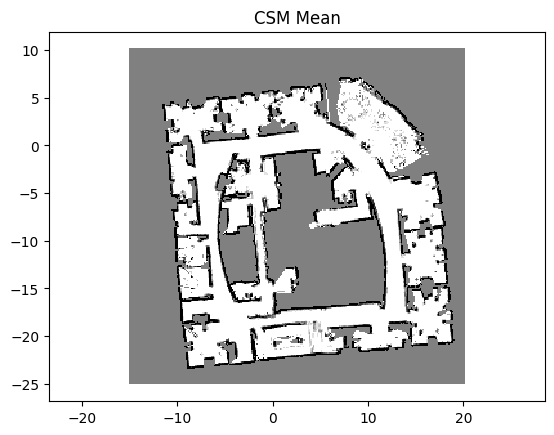

Plotting map variance


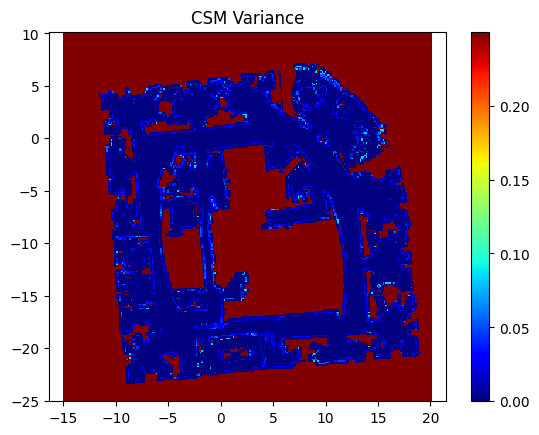

In [19]:
# load data
dataLoad = loadmat(os.path.join('data','sample_Intel_dataset.mat'))
robotPose = dataLoad['robotPose']
laserScan = dataLoad['laserScan']

# initialize map
ogm = ogm_CSM()

# build map
ogm.construct_map(robotPose, laserScan)
ogm.build_ogm()

# plot map
plot_mean(ogm, 'CSM Mean', './figures/ogm_intel_CSM_mean.png')
plot_variance(ogm, 'CSM Variance', './figures/ogm_intel_CSM_variance.png')

### Task 2: Continuous Counting Sensor Model (25 points)

#### Submission
Please fill the **TODO**s in the function contained in **ogm_continuous_CSM.py** and submit the file to gradescope.

In [14]:
# load data
dataLoad = loadmat(os.path.join('data','sample_Intel_dataset.mat'))
robotPose = dataLoad['robotPose']
laserScan = dataLoad['laserScan']

A. (25 pts) Implement a 2D continuous counting sensor model (CSM) in `ogm_continuous_CSM.py`. For debugging, visualize your map with `grid_size = 0.135 m` and plot its associated variance map.
- 15 pts: `continuous_CSM()`
- 10 pts: `build_ogm()`

  0%|          | 0/68121 [00:00<?, ?it/s]

100%|██████████| 68121/68121 [01:54<00:00, 595.10it/s]


Plotting map mean


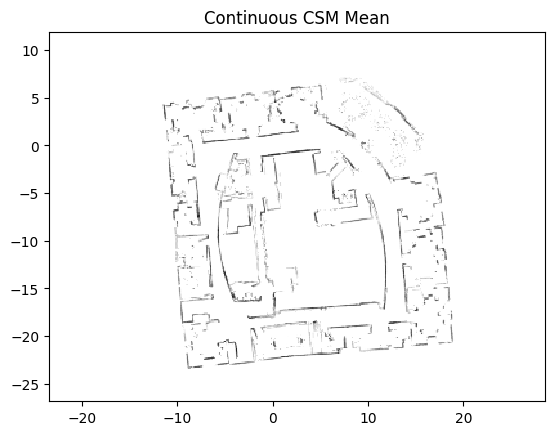

Plotting map variance


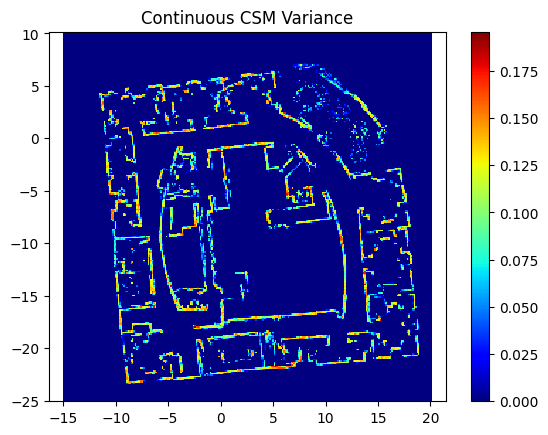

In [15]:
# initialize map
ogm = ogm_continuous_CSM()

# build map
ogm.construct_map(robotPose, laserScan)
ogm.build_ogm()

# plot map
plot_mean(ogm, 'Continuous CSM Mean', './figures/ogm_intel_continuous_CSM_mean.png')
plot_variance(ogm, 'Continuous CSM Variance', './figures/ogm_intel_continuous_CSM_variance.png')

B. (0 pts) Generate the map and the variance map using `grid_size = [0.135, 0.270, 0.5]`. Study the effects of varying the map resolution on the map inference. This question will not be graded. 

100%|██████████| 68121/68121 [01:53<00:00, 597.93it/s]


Plotting map mean


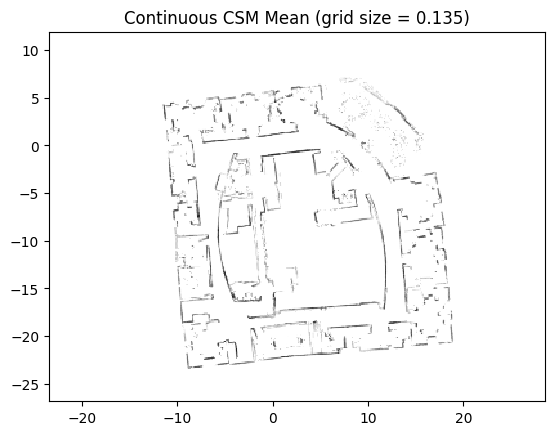

Plotting map variance


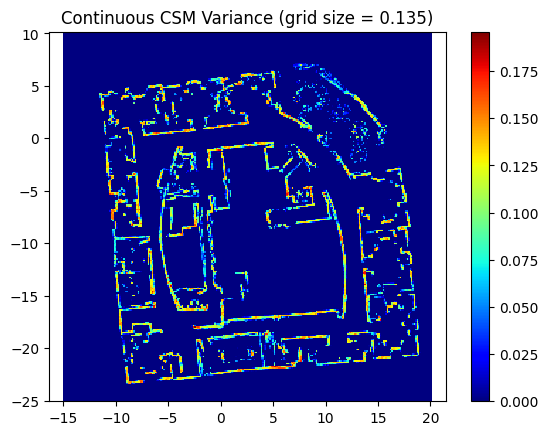

100%|██████████| 17161/17161 [00:29<00:00, 583.33it/s]


Plotting map mean


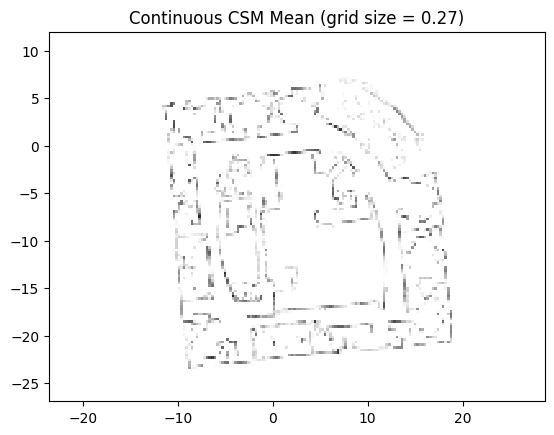

Plotting map variance


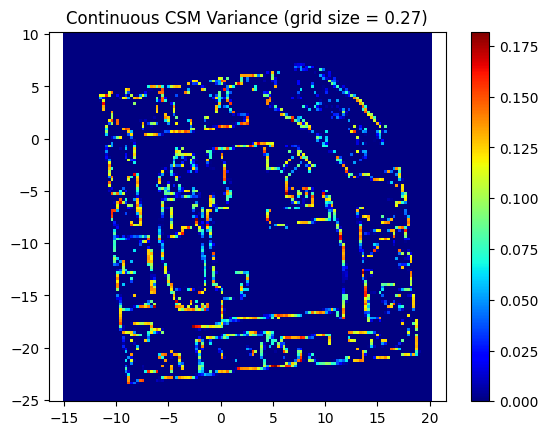

100%|██████████| 5041/5041 [00:08<00:00, 594.80it/s]


Plotting map mean


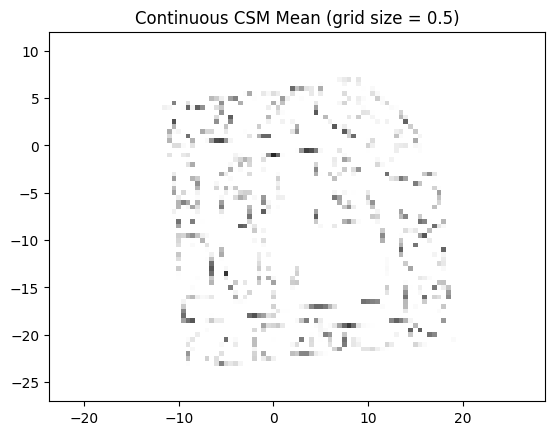

Plotting map variance


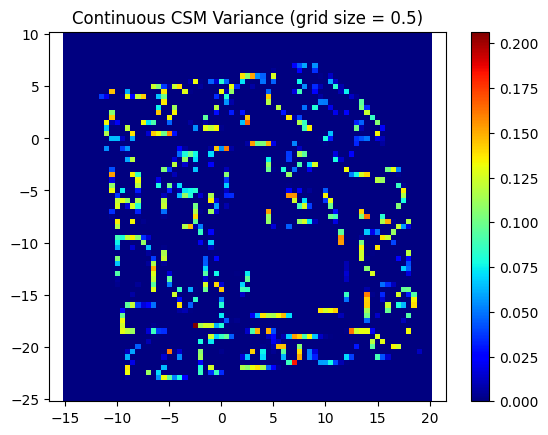

In [8]:
grid_sizes = [0.135, 0.270, 0.5]

for grid_size in grid_sizes:
    # initialize map
    ogm = ogm_continuous_CSM(grid_size=grid_size)
    
    # build map
    ogm.construct_map(robotPose, laserScan)
    ogm.build_ogm()
    
    # plot map
    plot_mean(ogm, 'Continuous CSM Mean (grid size = ' + str(grid_size) + ')', './figures/ogm_intel_continuous_CSM_mean_' + str(grid_size) + '.png')
    plot_variance(ogm, 'Continuous CSM Variance (grid size = ' + str(grid_size) + ')', './figures/ogm_intel_continuous_CSM_variance_' + str(grid_size) + '.png')

### Task 3: Discrete Semantic Counting Sensor Model (25 points)

#### Submission
Please fill the **TODO**s in the function contained in **ogm_S_CSM.py** and submit the file to gradescope.

A. (25 pts) Implement a semantic counting sensor model (S-CSM) in `ogm_S_CSM.py`.
For debugging, visualize your map with `grid_size = 0.135 m` and visualize the variance of the class with highest probabilities at each grid. 
- 15 pts: `S_CSM()`
- 10 pts: `build_ogm()`

In [22]:
# load data
dataLoad = loadmat(os.path.join('data','sample_Intel_dataset_semantic.mat'))
robotPose = dataLoad['robotPose']
laserScan = dataLoad['laserScan']

# initialize map
ogm = ogm_S_CSM()

# build map
ogm.construct_map(robotPose, laserScan)
ogm.build_ogm()

# plot
plot_semantic(ogm, 'S-CSM Mean', './figures/ogm_intel_S_CSM_mean.png')
plot_variance(ogm, 'S-CSM Variance', './figures/ogm_intel_S_CSM_variance.png')

 40%|████      | 27580/68121 [00:17<00:26, 1557.65it/s]

### Task 4: Countinuous Semantic Counting Sensor Model (25 points)

#### Submission
Please fill the **TODO**s in the function contained in **ogm_continuous_S_CSM.py** and submit the file to gradescope.

In [152]:
dataLoad = loadmat(os.path.join('data','sample_Intel_dataset_semantic.mat'))
robotPose = dataLoad['robotPose']
laserScan = dataLoad['laserScan']

A. (25 pts) Implement a continuous semantic counting sensor model (S-CSM) in `ogm_continuous_S_CSM.py` using the defined kernel. For debugging, visualize your map and variance of the class with highest probabilities at each grid.
- 15 pts: `continuous_S_CSM()`
- 10 pts: `build_ogm()`

In [ ]:
# initialize map
ogm = ogm_continuous_S_CSM()

# build map
ogm.construct_map(robotPose, laserScan)
ogm.build_ogm()

# plot
plot_semantic(ogm, 'Continuous S-CSM Mean', './figures/ogm_intel_continuous_S_CSM_mean.png')
plot_variance(ogm, 'Continuous S-CSM Variance', './figures/ogm_intel_continuous_S_CSM_variance.png')

B. (0 pts) Generate the map and the variance map using `grid_size = [0.135, 0.270, 0.5]`. Study the effects of varying the map resolution on the map inference. This question will not be graded. 

In [ ]:
grid_sizes = [0.135, 0.270, 0.5]

for grid_size in grid_sizes:
    # initialize map
    ogm = ogm_continuous_S_CSM(grid_size=grid_size)

    # build map
    ogm.construct_map(robotPose, laserScan)
    ogm.build_ogm()
    
    # plot
    plot_semantic(ogm, 'Continuous S-CSM Mean (grid size = ' + str(grid_size) + ')', './figures/ogm_intel_continuous_S_CSM_mean_' + str(grid_size) + '.png')
    plot_variance(ogm, 'Continuous S-CSM Variance (grid size = ' + str(grid_size) + ')', './figures/ogm_intel_continuous_S_CSM_variance_'  + str(grid_size) + '.png')

### Task 5: BKI Semantic Mapping (20 bonus points)

Build and run the [BKI Semantic Mapping](https://github.com/ganlumomo/BKISemanticMapping) on KITTI semantics dataset [5] sequence 04. Submit screenshots of the visualization in RViz in your pdf.

Notice the system dependencies:

- **Ubuntu system:** The mapping algorithm is built on Ubuntu system. It has been tested on Ubuntu 16.04 and Ubuntu 18.04. If you don't have an Ubuntu system, you can create a virtual machine.
- **ROS system:** The mapping algorithm has been tested on ROS Kinetic and ROS Melodic. You can follow the installation guide for ROS in [the documentation](http://wiki.ros.org/melodic/Installation).
- **A catkin workspace (catkin_ws):** You can follow the steps in [the tutorial](http://wiki.ros.org/catkin/Tutorials/create_a_workspace).

Read the README in the repository and do the following steps: 
1. Build the repository with catkin. Run the following commands in your catkin workspace (catkin_ws):
   - `cd ~/catkin_ws/src/`
   - `git clone https://github.com/ganlumomo/BKISemanticMapping`
   - `cd ..`
   - `catkin_make`
   - `source ~/catkin_ws/devel/setup.bash`

2. Download semantic KITTI dataset sequence 04 data from [this link](https://drive.google.com/file/d/19Dv1jQqf-VGKS2qvbygFlUzQoSvu17E5/view) and uncompress it into the data folder.

3. Run the demo with the following command:
   - roslaunch semantic_bki semantickitti_node.launch


4. The inferene results of each frame are saved to `.txt` files in `./BKISemanticMapping/data/semantickitti_04/evalutations/`. After the run has completed, submit the evalutations from the last frame to gradescope. The file to submit is named `000099.txt`.

   **Note:** It is expected that the program will stop at the 99th `.bin` file. To process more files, you can change the corresponding parameter in `semantickitti.yaml` under the path `./BKISemanticMapping/config/datasets`.


### 5) References

1. Intel Dataset: [http://www2.informatik.uni-freiburg.de/~stachnis/datasets.html](http://www2.informatik.uni-freiburg.de/~stachnis/datasets.html)
2. Task 1-2: [Doherty, K., Shan, T., Wang, J., & Englot, B. (2019). Learning-aided 3-D occupancy mapping with Bayesian generalized kernel inference. IEEE Transactions on Robotics, 35(4), 953-966.](https://ieeexplore.ieee.org/abstract/document/8713569)
3. Task 3-5: [Gan, L., Zhang, R., Grizzle, J. W., Eustice, R. M., & Ghaffari, M. (2020). Bayesian spatial kernel smoothing for scalable dense semantic mapping. IEEE Robotics and Automation Letters, 5(2), 790-797.](https://ieeexplore.ieee.org/abstract/document/8954837)
4. Task 5 Github repository: [https://github.com/ganlumomo/BKISemanticMapping](https://github.com/ganlumomo/BKISemanticMapping)
5. Semantics KITTI Dataset: [http://www.cvlibs.net/datasets/kitti/eval_semantics.php](http://www.cvlibs.net/datasets/kitti/eval_semantics.php)


### FAQ

1. **Q:** In Discrete Counting Sensor Model (Discrete CSM), the if-else statement in Algorithm~[1] Line 4, why does the absolute error between a range of pose and range of scan have to be within the grid size, i.e., $|r-z_l^k| < \frac{w_{obstacle}}{2}$?  
   **A:** It is similar to the occupancy map. The idea is that we want to find specific grids that are close to where the beam was stopped. This indicates an obstacle blocking the beam at that grid. If the distance from the robot to that grid is larger than the range we receive from the measurement, the grid is then either too close to the robot or too far away. If the grid is closer to the robot than the measurements, then it means the beam passes through it, and thus we should update it as free.

2. **Q:** When I discretize the Continuous Counting Sensor Model (Continuous CSM), I think the finer we make the discretization, the better. At the same time, if we discretize too finely, we may update data many times as the for loop would iterate over all the points, and we could have $d_2 < l$ multiple times. Should we do something like updating $\beta$ only for the closest point? Or should we never discretize smaller than the grid size?  
   **A:** As the algorithm states, $\beta$ can be calculated multiple times instead of updating the closest point. You can avoid adding $\beta$ several times within one grid by setting the step size close to the grid size.
